<a href="https://colab.research.google.com/github/jesmer/jesmer/blob/main/SoQ2022_Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summer of Quantum 2022 - Day 2
# Numerical Simulation of Quantum Systems with Python

Welcome to our hands-on exercise! 

This Jupyter notebook will guide you through working with circuits in QuTiP and then in Qiskit, compared with what you saw in class today..

**Remember to save a copy of this file to your own Google drive before you start working on it.**

In [ ]:
!pip install qutip 

import numpy as np

# from matplotlib.lines import Line2D
# from matplotlib import cm

import matplotlib.pyplot as plt
%matplotlib inline

from qutip import*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.7 MB 14.7 MB/s 


# Circuits with QuTiP

Today in class we've gone from thinking about spins and rotations to thinking about qubits and circuits. Now we'll see how to do this numerically.

Let's start by implementing an example from class:

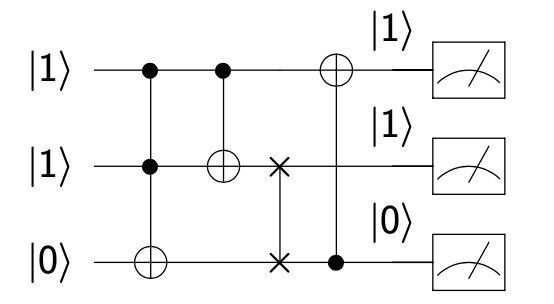

Remember, here the first gate is a Toffoli, the second is a CNOT, the third is a SWAP, and the third is another CNOT.

## The hard way

In principle we already have everything we need to perform this circuit. Let's try.

First, some definitions from yesterday:

In [ ]:
pi = np.pi

def Rx(theta) :
  return (-1j*sigmax()*theta/2).expm()
def Ry(theta) :
  return (-1j*sigmay()*theta/2).expm()
def Rz(theta) :
  return (-1j*sigmaz()*theta/2).expm()

up = spin_coherent(1/2,0,0)
dn = spin_coherent(1/2,pi,0)
kets = [up,dn]

X1 = 1j*Rx(pi)
I1 = qeye(2)

CNOT = Qobj([[1,0,0,0],
             [0,1,0,0],
             [0,0,0,1],
             [0,0,1,0]])
CNOT.dims = [[2,2], [2,2]]

And let me define a useful measurement operator, which will be used to measure the number states of the qubits

The details are not important, but look at the diagonal of 

In [ ]:
def numN(Nq) :
  return sum((10**m)*tensor([qeye(2)]*(m)+[num(2)]+[qeye(2)]*(Nq-m-1)) for m in range(Nq) )

num3 = numN(3)
for q2 in [0,1] :
  for q1 in [0,1] :
    for q0 in [0,1] :
      psi = tensor(kets[q0],kets[q1],kets[q2])
      M = measurement.measure(psi,num3)

      print('For the state %d%d%d, num(3) measures: %03d' % (q2,q1,q0,M[0]))


For the state 000, num(3) measures: 000
For the state 001, num(3) measures: 001
For the state 010, num(3) measures: 010
For the state 011, num(3) measures: 011
For the state 100, num(3) measures: 100
For the state 101, num(3) measures: 101
For the state 110, num(3) measures: 110
For the state 111, num(3) measures: 111


Next, let's prepare the initial state:

(Note: I'm using the convention that the least-siginficant bit is at the top, so that the state is 011)

In [ ]:
psi = tensor(kets[1],kets[1],kets[0])
print(psi)
print()
print('%03d' % measurement.measure(psi,num3)[0])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

011


Then, apply a Toffoli gate. We can construct that like we did the CNOT:

In [ ]:
Toff = Qobj([[1,0,0,0,0,0,0,0],
             [0,1,0,0,0,0,0,0],
             [0,0,0,1,0,0,0,0],
             [0,0,1,0,0,0,0,0],
             [0,0,0,0,1,0,0,0],
             [0,0,0,0,0,1,0,0],
             [0,0,0,0,0,0,0,1],
             [0,0,0,0,0,0,1,0]
             ])
Toff.dims = [[2,2,2], [2,2,2]]

psi = Toff*psi
print(psi)
print()
print('%03d' % measurement.measure(psi,num3)[0])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

111


Then, a CNOT. 

We already have a CNOT but we have to increase the operator to work on three qubits, first! For that, we use *tensor* again.

In [ ]:
CNOTI = tensor(CNOT,qeye(2))

psi = CNOTI*psi
print(psi)
print()
print('%03d' % measurement.measure(psi,num3)[0])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]

101


Then, a swap:

In [ ]:
SWAP = Qobj([[1,0,0,0],
             [0,0,1,0],
             [0,1,0,0],
             [0,0,0,1]])
SWAP.dims = [[2,2], [2,2]]

SWAPI = tensor(qeye(2),SWAP)

psi = SWAPI*psi
print(psi)
print()
print('%03d' % measurement.measure(psi,num3)[0])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

011


And finally, another CNOT. 

We already have a CNOT, but it acts on the wrong qubits! We have to define yet another operator.

In [ ]:
SWAP31I2 = Qobj([[1,0,0,0,0,0,0,0],
                 [0,0,0,0,0,1,0,0],
                 [0,0,1,0,0,0,0,0],
                 [0,0,0,0,0,0,0,1],
                 [0,0,0,0,1,0,0,0],
                 [0,1,0,0,0,0,0,0],
                 [0,0,0,0,0,0,1,0],
                 [0,0,0,1,0,0,0,0]])
SWAP31I2.dims = [[2,2,2], [2,2,2]]

psi = SWAP31I2*psi
print(psi)
print()
print('%03d' % measurement.measure(psi,num3)[0])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

011


We got the right result! But that was very difficult. Let's see an easier way.

## The easy way

There is, naturally, a better way to do it. Inside of QuTiP there is a sub-package called qip (for quantum information processing) and 

In [ ]:
from qutip.qip import circuit

Two of the basic commands we'll use are

*QubitCircuit()*

which generates a new circuit object

*Gate()*

which accesses a library of gates

Let's repeat the calculation above.

In [ ]:
QC = circuit.QubitCircuit(3)

QC.add_gate(circuit.Gate(name='TOFFOLI',targets=[2],controls=[0,1]))

QC.add_gate(circuit.Gate(name='CNOT',targets=[1],controls=[0]))

QC.add_gate(circuit.Gate(name='SWAP',targets=[1,2]))

QC.add_gate(circuit.Gate(name='CNOT',targets=[0],controls=[2]))

Here, the first line creates a new quantum circuit object with three qubits.

Each subsequent line adds a gate to the circuit, which is simply described by its name, and by the qubits it is acting upon (divided into control and target qubits in the case of CNOT and Toffoli).

Once we have that, we can simply run the circuit and get the same result:

In [ ]:
psi = tensor(kets[1],kets[1],kets[0])

psiout = QC.run(state=psi)

print(psiout)
print('%03d' % measurement.measure(psi,num3)[0])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
011


This is much easier, and we could probably stick with QuTiP for most things, but we're going to switch gears and use another package for the rest of our time. 

The basic reason for this is that the QIP functionality in QuTiP is relatively new, and doesn't play so nice with Colab for now when it comes to printing out circuits. In addition, it's always good to see multiple tools for doing these things, even if they are mostly similar. 

Luckily, there are some older packages that do the same. As far as I can tell each of the big industry players in the field have their own, including Microsoft's [Azure Quantum](https://docs.microsoft.com/en-us/azure/quantum/), Amazon's [Braket](https://aws.amazon.com/braket/) and the two perhaps most well known, Google's [Cirq](https://quantumai.google/cirq) and IBM's [Qiskit](https://qiskit.org/).

# Circuits with Qiskit

Without endorsing any of those, today we'll work with Qiskit. The prime reason for that is that later in the week you'll play with IBM's Q Experience, and if you want to do more of that, Qiskit is the easiest way to do so.

In [ ]:
!pip install qiskit[visualization]

import qiskit as qk
from qiskit.providers import aer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 33.6 MB/s 
     |████████████████████████████████| 18.0 MB 47.0 MB/s 
     |████████████████████████████████| 240 kB 57.9 MB/s 
     |████████████████████████████████| 162 kB 56.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 112 kB 54.1 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 1.6 MB 47.0 MB/s 
     |████████████████████████████████| 943 kB 50.6 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
     |████████████████████████████████| 4.1 MB 41.8 MB/s 
     |████████████████████████████████| 112 kB 69.7 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.0-py3-none-any.whl size=12028 sha256=38c1f1ecac69644391307c6b4a23ba437b71c08da84ee36136d21f94e1601f31
 

## Circuit Syntax

The syntax for Qiskit is similar to what we've just seen. You can see the details [here](https://qiskit.org/documentation/), or a simpler tutorial [here](https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html).

Let's create the same circuit again

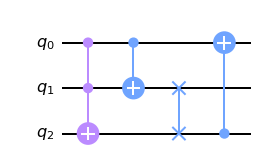

In [ ]:
QC = qk.QuantumCircuit(3)

QC.toffoli(0,1,2)

QC.cnot(0,1)

QC.swap(1,2)

QC.cnot(2,0)

QC.draw('mpl')

The last command was new, and let us plot out the circuit - a very handy tool. Here the parameter *'mpl'* is telling Qiskit to use matplotlib to do the drawing; you can also try it out without the parameter and see a slightly more primitive drawing.

In [ ]:
psi = qk.quantum_info.Statevector.from_int(0b011,2**3)
print('Initial state:')
display(psi.draw('latex'))

psi = psi.evolve(QC)

print('Final state:')
display(psi.draw('latex'))


Initial state:


<IPython.core.display.Latex object>

Final state:


<IPython.core.display.Latex object>

And here we see how to define a state in Qiskit and how apply a circuit to it.

### Exercise 3: Implementing the Toffoli gate

Let's try this hands on. Below, try to recreate the Toffoli circuit you saw in class. Then plot it to see that you got the right result.

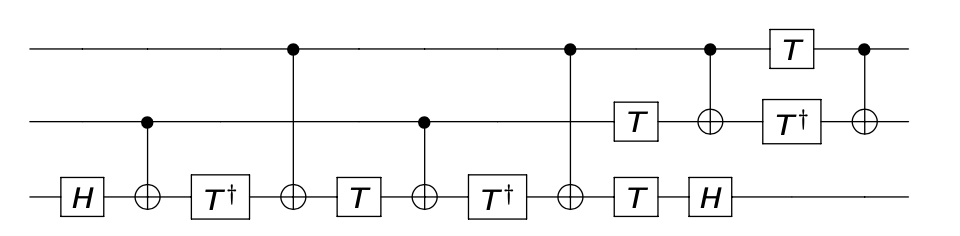

In [ ]:
# Your code here

Note that the drawing you get might be a bit different from what you see above, but if you look carefully they are equivalent - do you see why?

## Measurement and classical registers

Let's add one more thing that Ari's circuit had: measurement.

To do this, we will add another component, a classical register. Measurement turns quantum information into classical information; in the quantum computing way of thinking, we need some classical bits to put the information in. See how we do this below:

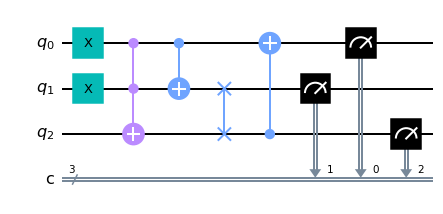

In [ ]:
QC = qk.QuantumCircuit(3,3)

QC.x(0)
QC.x(1)

QC.toffoli(0,1,2)
QC.cnot(0,1)
QC.swap(1,2)
QC.cnot(2,0)

for m in range(3) :
  QC.measure(m,m)

QC.draw('mpl')

You can see that in the first command I've just added a second parameter that is the number of classical bits I'm going to use, and then at the end I specify which classical bit to measure each qubit into.

The other thing I've done is add a single qubit X gate to the two qubits that were initiated as $|1\rangle$. This is because the convention in quantum computing is that each new qubit is initialized to $|0\rangle$; if you want it to be something else you explicity add the circuit element that does this.

## Running Experiments

We saw above how to work with a state and a circuit. But usually we want to compare our results to experiment, and so what we really want are measurements.

In Qiskit, measurements are simulated by a dedicated backend, which we call to implement the circuit. 

The idea here is that once we have real machines (e.g. with the Quantum experience), you can use the same syntax to call them and get real quantum results!

Let's see how this works.

In [ ]:
backend = qk.providers.aer.AerSimulator()

QC_compiled = qk.transpile(QC, backend)

QC_job = backend.run(QC_compiled, shots=1000)

QC_res = QC_job.result()

print(QC_res.get_counts())

{'011': 1000}


Here the first command calls a simulation backend called Aer that's provided by Qiskit.

The next two commands compile our circuit into it and "running" the experiment, asking to run it 1000 times.

We then get the results and print out the counts: how many times each combination of results came out. This is quite boring here, since the result of a the circuit was a definite state!

Let's see how this goes with a slightly more interesting circuit:

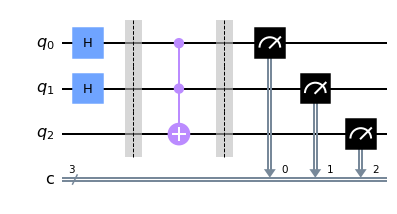

In [ ]:
QC = qk.QuantumCircuit(3,3)
QC.h(0)
QC.h(1)
QC.barrier()
# QC = QC.compose(toffcirc)
QC.toffoli(0,1,2)
QC.barrier()
for i in range(3) :
  QC.measure(i,i)

QC.draw('mpl')

We can see two new commands here,

*compose()* let us add the circuit we'd already designed to the new circuit

*barrier()* prevents what happened above where the circuit was collapsed to its shortest form. This is useful for clarity when plotting it out.

Let's run it and see what happens. What do we expend to see?

In [ ]:
QC_compiled = qk.transpile(QC, backend)
QC_job = backend.run(QC_compiled, shots=1000)
QC_res = QC_job.result()

print(QC_res.get_counts())

{'111': 260, '001': 237, '000': 239, '010': 264}


## Parameters

Let's introduce one more idea. It's useful to have define parameters in a circle, that you can vary to get different. This is simply a convenience - instead of defining a different circuit with e.g. a $\pi/4$ rotation and a $\pi/2$ rotation we define one circuit and vary the parameter.

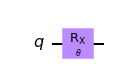

In [ ]:
thetaP = qk.circuit.Parameter(r'$\theta$')
QC = qk.QuantumCircuit(1) 
QC.rx(thetaP,0)

QC.draw('mpl')

To run the circuit we have to "bind" the parameter to a value, like this:

In [ ]:
psi = qk.quantum_info.Statevector.from_int(0,2)
print("Initial state:")
for theta in np.linspace(0,pi,5) :
  print("Output with theta = %.2f*pi:" % (theta/pi))
  display(psi.evolve(QC.bind_parameters({thetaP:theta})).draw('latex'))

Initial state:
Output with theta = 0.00*pi:


<IPython.core.display.Latex object>

Output with theta = 0.25*pi:


<IPython.core.display.Latex object>

Output with theta = 0.50*pi:


<IPython.core.display.Latex object>

Output with theta = 0.75*pi:


<IPython.core.display.Latex object>

Output with theta = 1.00*pi:


<IPython.core.display.Latex object>

### Exercise 4: Putting it all together

Let's put it all together as a final exercise.

Generate the circuit plotted below, and plot the probabilites of each of the outcomes of the measurement as a function of $\theta$.

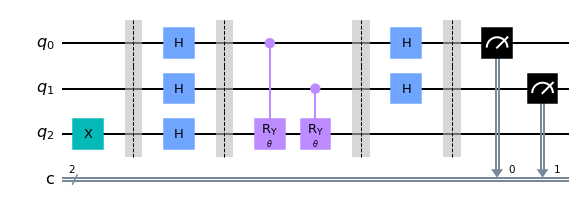

In [ ]:
### Your code here